In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import keras
import csv
import torch
from math import sqrt
from torch import nn
from pylab import rcParams
from torch.nn import CrossEntropyLoss
from tensorflow.python.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from tensorflow.keras import Input, layers
import tensorflow.keras.utils as np_utils 
from tensorflow.python.keras import regularizers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# Read Data

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    database_path= "/content/drive/My Drive/"
    dataset = os.path.join(database_path,"fer2013.csv")
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

  

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
data = pd.read_csv(dataset)
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [ ]:
emotion_label = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))

In [ ]:
rcParams['figure.figsize']=15,10
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
x= data['pixels']
x= np.array(x)
y=data['emotion']
y=np.array(y)
print(type(x[0]))
print(type(y[0]))

<class 'str'>
<class 'numpy.int64'>


In [ ]:
print("type of x",x.shape)
print("type of y",y.shape)

type of x (35887,)
type of y (35887,)


In [ ]:
channel = 1
num_class=7
de_height = 48
de_width = 48
de_depth = 1
batch_size = 128
val_step = 2000
test_batch_size = 128
shuffle_pool_size = 3000
generation = 5000
save_flag = "False"
epochs = 30
height = int(sqrt(len(data.pixels[0].split()))) 
width = int(height)


In [ ]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import np_utils
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt



# Data Split

In [ ]:
train_set = data[(data.Usage == 'Training')]
val_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')] 

X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)


In [ ]:
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]
print(num_train)
print(num_val)
print(num_test)


28709
3589
3589


In [ ]:
y_train = train_set.emotion
y_train = np_utils.to_categorical(y_train, num_class) 
y_val = val_set.emotion 
y_val = np_utils.to_categorical(y_val, num_class) 
y_test = test_set.emotion 
y_test = np_utils.to_categorical(y_test, num_class)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(28709, 7)
(3589, 7)
(3589, 7)


In [ ]:
datagen = ImageDataGenerator(rescale=1./255, rotation_range =10, horizontal_flip = True, width_shift_range= 0.1,height_shift_range=0.1, fill_mode='nearest')
testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)
batch_size = 64

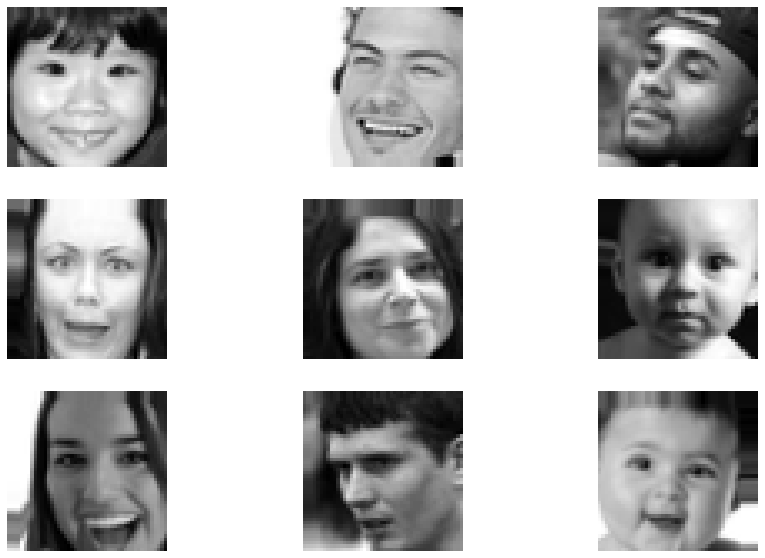

In [ ]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break 

In [ ]:
train_flow = datagen.flow(X_train,y_train,batch_size=batch_size)
val_flow = testgen.flow(X_val,y_val,batch_size=batch_size)
test_flow = testgen.flow(X_test,y_test,batch_size=batch_size)

# CNN

Use keras build CNN model 

In [ ]:
from keras.optimizers import SGD

In [ ]:
model = Sequential()

In [ ]:
#first layer
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#second layer
model.add(Conv2D(128,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#third layer
model.add(Conv2D(256,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#fourth layer
model.add(Conv2D(256,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

#first fully connect
model.add(Dense(2048))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))

#second fully connect
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(7,activation="softmax"))

sgd=SGD(lr=0.01, decay= 1e-6,momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Training

In [ ]:
history_fit = model.fit_generator(train_flow, steps_per_epoch=len(X_train)/batch_size,epochs=200,validation_data=val_flow,validation_steps=len(X_val)/batch_size)


# Evaluation

In [ ]:
%matplotlib inline

In [ ]:
loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test Loss 0.8700464963912964
Test Acc: 0.6868208646774292


In [ ]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 5ms/step - loss: 0.8700 - accuracy: 0.6868
Test Loss 0.8700465559959412
Test Acc: 0.6868208646774292


In [ ]:
loss = model.evaluate(X_val/255., y_val) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 5ms/step - loss: 0.9031 - accuracy: 0.6824
Test Loss 0.903076708316803
Test Acc: 0.6823627948760986


<Figure size 432x288 with 0 Axes>

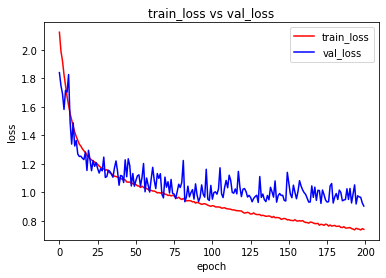

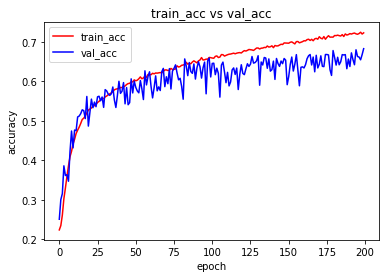

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

train_loss=history_fit.history['loss']
val_loss=history_fit.history['val_loss']
train_acc=history_fit.history['accuracy']
val_acc=history_fit.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [ ]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

In [ ]:
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

# Write Model

In [ ]:
import IPython

display(IPython.display.Javascript('''
  const promise = new Promise((resolve, reject) => {
    const script = document.createElement('script');
    script.src = 'data:,window.value = "hello world!"';
    script.onload = resolve;
    script.onerror = reject;
    document.head.appendChild(script);
  });
  // Pause subsequent outputs until the script has been loaded.
  google.colab.output.pauseOutputUntil(promise);
'''))

display(IPython.display.Javascript('''
    // Can immediately reference scripts loaded earlier since
    // output processing was blocked on them.
    document.body.appendChild(document.createTextNode(window.value));
'''))


In [ ]:
model_json = model.to_json()
with open("project_model.json","w") as json_file:
    json_file.write(model_json)
    model.save_weights('/content/'+'/model_weight.h5')
    model.save('/content/'+'/model.h5')